# Goal

* Initial testing, assessment, and debugging of SIPSim qSIP data
* **Parameters**
  * 12C control & 13C treatment gradients
  * n-reps = 3 (n-total = 6)
  * % atom excess = 100%
  * % taxa with incorporation = 10%

# Init

In [1]:
import os
import glob
import re
import nestly
%load_ext rpy2.ipython

In [2]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)
library(phyloseq)

## BD for G+C of 0 or 100
BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


# Nestly

* assuming fragments already simulated

In [3]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/'
buildDir = os.path.join(workDir, 'default_rep3')
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

fragFile = '/home/nick/notebook/SIPSim/dev/bac_genome1147/validation/ampFrags.pkl'
genomeIndex = '/var/seq_data/ncbi_db/genome/Jan2016/bac_complete_spec-rep1_rn/genome_index.txt'

# simulation parameters
prefrac_comm_abundance = '1e9'
n_gradient_reps = 3
nprocs = 24

In [30]:
# building tree structure
nest = nestly.Nest()

## varying params
nest.add('abs', [prefrac_comm_abundance])

## set params
nest.add('percIncorp', [100], create_dir=False)
nest.add('percTaxa', [10], create_dir=False)
nest.add('n_gradient_reps', [n_gradient_reps], create_dir=False)
nest.add('np', [nprocs], create_dir=False)


### input/output files
nest.add('buildDir', [buildDir], create_dir=False)
nest.add('R_dir', [R_dir], create_dir=False)
nest.add('fragFile', [fragFile], create_dir=False)
nest.add('genomeIndex', [genomeIndex], create_dir=False)

# building directory tree
nest.build(buildDir)

# bash file to run
bashFile = os.path.join(buildDir, 'SIPSimRun.sh')

In [31]:
%%writefile $bashFile
#!/bin/bash

export PATH={R_dir}:$PATH

echo '#-- SIPSim pipeline --#'
echo '# converting fragments to KDE'
SIPSim fragment_KDE \
    {fragFile} \
    > ampFrags_KDE.pkl
    
echo '# adding diffusion'    
SIPSim diffusion \
    ampFrags_KDE.pkl \
    --np {np} \
    > ampFrags_KDE_dif.pkl    

echo '# adding DBL contamination'
SIPSim DBL \
    ampFrags_KDE_dif.pkl \
    --np {np} \
    > ampFrags_KDE_dif_DBL.pkl      
    
echo '# making incorp file'
SIPSim incorpConfigExample \
  --percTaxa {percTaxa} \
  --percIncorpUnif {percIncorp} \
  --n_reps 3 \
  > {percTaxa}_{percIncorp}_{n_gradient_reps}.config

echo '# making community file'
!cd $workDir; \
    SIPSim communities \
    --config {percTaxa}_{percIncorp}_{n_gradient_reps}.config \
    {genomeIndex} \
    > comm.txt    

echo '# adding isotope incorporation to BD distribution'
SIPSim isotope_incorp \
    ampFrags_KDE_dif_DBL.pkl \
    {percTaxa}_{percIncorp}_{n_gradient_reps}.config \
    --comm comm.txt \
    --np {np} \
    > ampFrags_KDE_dif_DBL_inc.pkl
    
echo '# calculating BD shift from isotope incorporation'
SIPSim BD_shift \
    ampFrags_KDE_dif_DBL.pkl \
    ampFrags_KDE_dif_DBL_inc.pkl \
    --np {np} \
    > ampFrags_KDE_dif_DBL_inc_BD-shift.pkl

echo '# simulating gradient fractions'
SIPSim gradient_fractions \
    comm.txt > fracs.txt 

echo '# simulating an OTU table'
SIPSim OTU_table \
    ampFrags_KDE_dif_DBL_inc.pkl \
    comm.txt \
    fracs.txt \
    --abs {abs} \
    --np {np} \
    > OTU_abs{abs}.txt
    
echo '# simulating PCR'
SIPSim OTU_PCR \
    OTU_abs{abs}.txt \
    > OTU_abs{abs}_PCR.txt    
    
echo '# subsampling from the OTU table (simulating sequencing of the DNA pool)'
SIPSim OTU_subsample \
    OTU_abs{abs}_PCR.txt \
    > OTU_abs{abs}_PCR_sub.txt
        
echo '# making a wide-formatted table'
SIPSim OTU_wideLong -w \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_w.txt
    
echo '# making metadata (phyloseq: sample_data)'
SIPSim OTU_sampleData \
    OTU_abs{abs}_PCR_sub.txt \
    > OTU_abs{abs}_PCR_sub_meta.txt
    
    
echo '# Removing control.json file'    
rm -f control.json

Writing /home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP_rep3/SIPSimRun.sh


In [32]:
!chmod 777 $bashFile
!cd $workDir; \
    nestrun  --template-file $bashFile -d qSIP_rep3 --log-file log.txt -j 1

2016-01-18 10:51:23,348 * INFO * Template: ./SIPSimRun.sh
2016-01-18 10:51:23,349 * INFO * [86828] Started ./SIPSimRun.sh in qSIP_rep3/1e9
2016-01-18 11:25:40,332 * INFO * [86828] qSIP_rep3/1e9 Finished with 0


# qSIP

In [77]:
# building tree structure
nest = nestly.Nest()

## varying params
nest.add('abs', [prefrac_comm_abundance])
nest.add('disp_param', [1,5,10,100,1000])

# unvarying params
expDesignFile = os.path.join(buildDir, 'exp_design.txt')
nest.add('expDesignFile', [expDesignFile], create_dir=False)
nest.add('buildDir', [buildDir], create_dir=False)

# building directory tree
nest.build(buildDir)

# bash file to run
bashFile = os.path.join(buildDir, 'qSIPRun.sh')

In [78]:
%%writefile $expDesignFile

1	control
2	treatment
3	control
4	treatment
5	control
6	treatment

Overwriting /home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/exp_design.txt


In [79]:
%%writefile $bashFile
#!/bin/bash

# qSIP
SIPSim qSIP \
    --reps 3 -r {disp_param} \
    {buildDir}/{abs}/OTU_abs1e9.txt {buildDir}/{abs}/OTU_abs1e9_PCR_sub.txt \
    > OTU_abs1e9_PCR_sub_qSIP.txt
        
# atom excess
SIPSim qSIP_atomExcess \
    OTU_abs1e9_PCR_sub_qSIP.txt \
    {expDesignFile} \
    > OTU_abs1e9_PCR_sub_qSIP_atom.txt 

Overwriting /home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/qSIPRun.sh


In [80]:
!chmod 777 $bashFile
!cd $workDir; \
    nestrun  --template-file $bashFile -d default_rep3 --log-file log.txt -j 10

2016-01-18 14:31:46,131 * INFO * Template: ./qSIPRun.sh
2016-01-18 14:31:46,133 * INFO * [23914] Started ./qSIPRun.sh in default_rep3/1e9/1000
2016-01-18 14:31:46,134 * INFO * [23915] Started ./qSIPRun.sh in default_rep3/1e9/100
2016-01-18 14:31:46,136 * INFO * [23917] Started ./qSIPRun.sh in default_rep3/1e9/10
2016-01-18 14:31:46,137 * INFO * [23919] Started ./qSIPRun.sh in default_rep3/1e9/1
2016-01-18 14:31:46,138 * INFO * [23921] Started ./qSIPRun.sh in default_rep3/1e9/5
2016-01-18 14:33:20,546 * INFO * [23915] default_rep3/1e9/100 Finished with 0
2016-01-18 14:33:20,739 * INFO * [23921] default_rep3/1e9/5 Finished with 0
2016-01-18 14:33:20,943 * INFO * [23917] default_rep3/1e9/10 Finished with 0
2016-01-18 14:33:21,008 * INFO * [23914] default_rep3/1e9/1000 Finished with 0
2016-01-18 14:33:21,206 * INFO * [23919] default_rep3/1e9/1 Finished with 0


# Analyzing the results

## qPCR values

In [81]:
qPCR_files = !find $buildDir -name "OTU_abs1e9_PCR_sub_qSIP.txt"
qPCR_files

['/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/1000/OTU_abs1e9_PCR_sub_qSIP.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/100/OTU_abs1e9_PCR_sub_qSIP.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/10/OTU_abs1e9_PCR_sub_qSIP.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/1/OTU_abs1e9_PCR_sub_qSIP.txt',
 '/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/5/OTU_abs1e9_PCR_sub_qSIP.txt']

In [85]:
%%R -i qPCR_files
# loading files
df = list()
for (x in qPCR_files){
    f = gsub('/home/nick/notebook/SIPSim/dev/bac_genome1147/qSIP/default_rep3/1e9/', '', x)
    f = gsub('/OTU_abs1e9_PCR_sub_qSIP.txt', '', f)
    df[[f]] = read.delim(x, sep='\t') %>%
        distinct(library, fraction) %>%
        select(-taxon) %>%
        as.data.frame()
    }
df = do.call('rbind', df)
df$file = gsub('\\.[0-9]+$', '', rownames(df))
rownames(df) = 1:nrow(df)
df = df %>%
    mutate(exp_design = ifelse(library %% 2 == 0, 'treatment', 'control'),
           library = library %>% as.character,
           file = file %>% as.numeric)
df %>% head(n=3)

  library   fraction BD_min BD_mid BD_max count  rel_abund total_qPCR_copies
1       1 -inf-1.660   -Inf  1.659  1.659   291 0.01319010            334911
2       2 -inf-1.660   -Inf  1.659  1.659   209 0.01315458            309886
3       3 -inf-1.660   -Inf  1.659  1.659   269 0.01264217            316976
  prop_abs_abund file exp_design
1           4418 1000    control
2             30 1000  treatment
3            137 1000    control


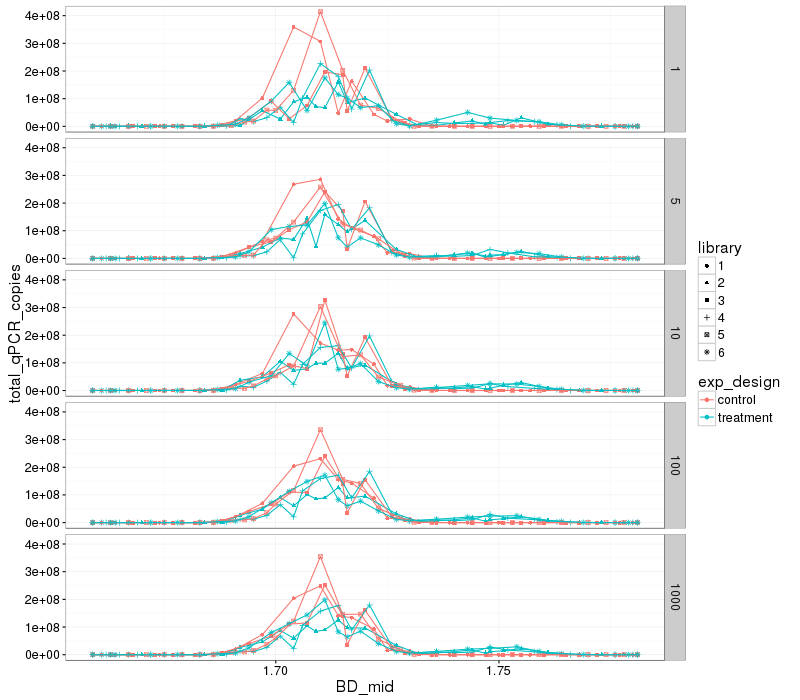

In [86]:
%%R -w 800 -h 700

ggplot(df, aes(BD_mid, total_qPCR_copies, 
               color=exp_design, group=library, shape=library)) +
    geom_point() +
    geom_line() +
    facet_grid(file ~ .) +
    labs(x = 'Buoyant density', '')
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
    